In [582]:
from astropy.coordinates import Angle
import astropy.units as u
from astropy.io import fits
from find_source import fits_data_index, summary, significant
import matplotlib.pyplot as plt
import numpy as np
import math
import io

In [583]:
def interpolation_kernel(s):
    dist = abs(s)
    if dist % 1 == 0:
        return 0
    if dist < 1:
        return (3/2 * (dist**3) - 5/2 * (dist**2) + 1)
    if dist < 2:
        return (-1/2 * (dist**3) + 5/2 * (dist**2) - 4 * dist + 2)
    return 0

In [584]:
def interpolation_function(x, node_x, node_val):
    num_nodes = len(node_x)
    N = num_nodes - 1

    # make sure inputs are valid
    if len(node_val) != num_nodes:
        raise ValueError("The number of nodes given does not match the number of node values given")
    h = node_x[1] - node_x[0]
    for i in range(1, N):
        if node_x[i+1] - node_x[i] != h:
            raise ValueError("Nodes are not uniformly spaced")

    # boundary conditions
    node_neg1 = node_x[0] - h
    node_Nplus1 = node_x[N] + h
    c_neg1 = node_val[2] - 3*node_val[1] + 3*node_val[0]
    c_Nplus1 = 3*node_val[N] - 3*node_val[N-1] + 3*node_val[N-2]

    # apply interpolation function
    interpolated_val = c_neg1 * interpolation_kernel((x - node_neg1) / h)
    for k in range(0, num_nodes):
        s = (x - node_x[k]) / h
        interpolated_val += node_val[k] * interpolation_kernel(s)
    interpolated_val += c_Nplus1 * interpolation_kernel((x - node_Nplus1) / h)
    return float(interpolated_val)

In [585]:
def thumbnail(fits_file: str, peak_coord: tuple, pts_bw_nodes: int = 4):

    i = fits_data_index(fits_file)

    # open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    # extract data array
    info = file[i]
    data = info.data

    data_array = data[0]
    min_flux = np.min(data_array)
    max_flux = np.max(data_array)

    header_data = fits.getheader(fits_file)

    beam_maj = Angle(header_data['BMAJ'], header_data['CUNIT1']).to_value('arcsec')
    pixel_scale = Angle(header_data['CDELT1'], header_data['CUNIT1']).to_value('arcsec')
    x_dim = header_data['NAXIS1']
    y_dim = header_data['NAXIS2']

    center = (round(x_dim/2), round(y_dim/2))

    # unnormalized the normalized coordinates
    unnorm_x = round((peak_coord[0] / pixel_scale) + center[0])
    unnorm_y = round((peak_coord[1] / pixel_scale) + center[1])

    delta = math.ceil((2.5 + (beam_maj/2))/ pixel_scale) # ~number pixels in search radius

    # make sure the ~5x5 arcsec box is actually inside the original image and handle issues if not
    new_data = data_array
    if unnorm_y - delta >= 0:
        new_data = data_array[unnorm_y - delta:]
    if unnorm_y + delta < y_dim:
        new_data = new_data[:(unnorm_y + delta) - y_dim + 1]
    if unnorm_x - delta >= 0:
        new_data = [row[unnorm_x - delta:] for row in new_data]
    if unnorm_x + delta < x_dim:
        new_data = [row[:(unnorm_x + delta) - x_dim + 1] for row in new_data]

    y_length = len(new_data)
    if y_length == 0:
        raise ValueError("Attempts to obtain a smaller image centered on the source resulted in an empty data array.")
    else:
        x_length = len(new_data[0])

    node_x = np.arange(0, x_length).tolist()
    node_y = np.arange(0, y_length).tolist()

    interpolated_data = []

    # first interpolate in x direction (add entries to rows)
    pts_bw_nodes = 4
    pts_spacing = 1 / (pts_bw_nodes + 1)


    # iterate through rows
    for row_num in range(y_length):
        temp = new_data[row_num].tolist()

        # iterate through nodes in row
        for i in range(x_length - 1):
            temp2 = []
            for j in range(1, pts_bw_nodes+1):
                x = i + j*pts_spacing
                temp2.append(interpolation_function(x, node_x=node_x, node_val=new_data[row_num]))
            temp = temp[:i-x_length+1] + temp2 + temp[i-x_length+1:]

        interpolated_data.append(temp)

    # interpolate in y direction (add rows)
    new_x_length = len(interpolated_data[0])

    temp = []
    for i in range((y_length - 1) * pts_bw_nodes):
        temp.append([])

    for col_num in range(new_x_length):
        temp2 = [row_num[col_num] for row_num in interpolated_data] # list of a single column's nodes

        # iterate through nodes in row so that we get rows to add
        for i in range(y_length - 1):
            for j in range(1, pts_bw_nodes+1):
                y = i + j*pts_spacing
                temp[i*pts_bw_nodes + j - 1].append(interpolation_function(y, node_x=node_y, node_val=temp2))

    for i in range(y_length - 1):
        interpolated_data = interpolated_data[:i-y_length+1] + temp[:pts_bw_nodes] + interpolated_data[i-y_length+1:]
        temp = temp[pts_bw_nodes:]

    fig, ax = plt.subplots()
    plt.axis('off')
    plt.title('normalized offset: {},\n pixel scale: {} arcsec'.format((round(peak_coord[0],2), round(peak_coord[1],2)), round(pixel_scale,2)))
    img = ax.imshow(interpolated_data, vmin=min_flux, vmax=max_flux)
    fig.colorbar(img)

In [586]:
# fits_file = '../data/11151/3c279.fits' # change this to actual path for testing

# ##### BELOW IS COPIED FROM region_stats #####
# i = fits_data_index(fits_file)

# # open FITS file
# try:
#     file = fits.open(fits_file)
# except:
#     print(f'Unable to open {fits_file}')

# # extract data array
# info = file[i]
# data = info.data

# ##### STARTING NEW-ISH STUFF #####
# data_array = data[0]
# min_flux = np.min(data_array)
# max_flux = np.max(data_array)

# header_data = fits.getheader(fits_file)

# beam_maj = Angle(header_data['BMAJ'], header_data['CUNIT1']).to_value('arcsec')
# pixel_scale = Angle(header_data['CDELT1'], header_data['CUNIT1']).to_value('arcsec')
# x_dim = header_data['NAXIS1']
# y_dim = header_data['NAXIS2']

# center = (round(x_dim/2), round(y_dim/2))

# ##### MADE THIS UP FOR TESTING PURPOSES #####
# peak_coord = (-0.6042424478692535, -0.6042424478692535) # normalized peak coordinates, will be an argument

# ##### CONTINUING MY CODE #####
# # unnormalized the normalized coordinates
# unnorm_x = round((peak_coord[0] / pixel_scale) + center[0])
# unnorm_y = round((peak_coord[1] / pixel_scale) + center[1])

# delta = math.ceil((2.5 + (beam_maj/2))/ pixel_scale) # ~number pixels in search radius

# # make sure the ~5x5 arcsec box is actually inside the original image and handle issues if not
# new_data = data_array
# if unnorm_y - delta >= 0:
#     new_data = data_array[unnorm_y - delta:]
# if unnorm_y + delta < y_dim:
#     new_data = new_data[:(unnorm_y + delta) - y_dim + 1]
# if unnorm_x - delta >= 0:
#     new_data = [row[unnorm_x - delta:] for row in new_data]
# if unnorm_x + delta < x_dim:
#     new_data = [row[:(unnorm_x + delta) - x_dim + 1] for row in new_data]

# y_length = len(new_data)
# if y_length == 0:
#     raise ValueError("Attempts to obtain a smaller image centered on the source resulted in an empty data array.")
# else:
#     x_length = len(new_data[0])

# # plotting image
# fig, ax = plt.subplots()
# plt.axis('off')
# img = ax.imshow(new_data, vmin=min_flux, vmax=max_flux)
# fig.colorbar(img)

IMPORTANT: data[y][x]

In [587]:
# node_x = np.arange(0, x_length).tolist()
# node_y = np.arange(0, y_length).tolist()

# interpolated_data = []

# # first interpolate in x direction (add entries to rows)
# pts_bw_nodes = 4
# pts_spacing = 1 / (pts_bw_nodes + 1)


# # iterate through rows
# for row_num in range(y_length):
#     temp = new_data[row_num].tolist()

#     # iterate through nodes in row
#     for i in range(x_length - 1):
#         temp2 = []
#         for j in range(1, pts_bw_nodes+1):
#             x = i + j*pts_spacing
#             temp2.append(interpolation_function(x, node_x=node_x, node_val=new_data[row_num]))
#         temp = temp[:i-x_length+1] + temp2 + temp[i-x_length+1:]

#     interpolated_data.append(temp)

# # interpolate in y direction (add rows)
# new_x_length = len(interpolated_data[0])

# temp = []
# for i in range((y_length - 1) * pts_bw_nodes):
#     temp.append([])

# for col_num in range(new_x_length):
#     temp2 = [row_num[col_num] for row_num in interpolated_data] # list of a single column's nodes

#     # iterate through nodes in row so that we get rows to add
#     for i in range(y_length - 1):
#         for j in range(1, pts_bw_nodes+1):
#             y = i + j*pts_spacing
#             temp[i*pts_bw_nodes + j - 1].append(interpolation_function(y, node_x=node_y, node_val=temp2))

# for i in range(y_length - 1):
#     interpolated_data = interpolated_data[:i-y_length+1] + temp[:pts_bw_nodes] + interpolated_data[i-y_length+1:]
#     temp = temp[pts_bw_nodes:]

In [588]:
# fig, ax = plt.subplots()
# plt.axis('off')
# img = ax.imshow(interpolated_data, vmin=min_flux, vmax=max_flux)
# fig.colorbar(img)

<Figure size 384x288 with 0 Axes>

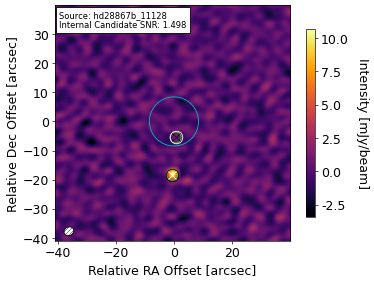

In [589]:
summ = summary('../data/multi_track/hd28867b_11128.fits', plot=True)

In [590]:
int_peaks = summ['int_peak_coord']
ext_peaks = summ['ext_peak_coord']

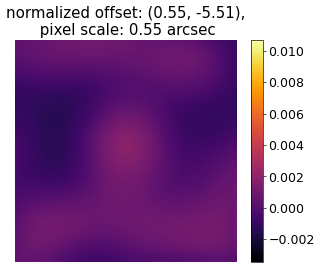

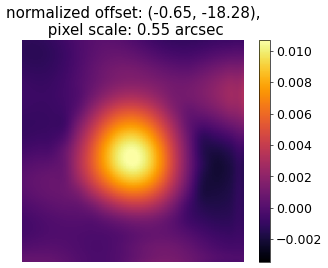

In [591]:
for coords in int_peaks:
    thumbnail(fits_file='../data/multi_track/hd28867b_11128.fits', peak_coord=coords, pts_bw_nodes=4)
for coords in ext_peaks:
    if type(ext_peaks) == list:
        thumbnail(fits_file='../data/multi_track/hd28867b_11128.fits', peak_coord=coords, pts_bw_nodes=4)

In [592]:
summ

{'field_center': (0, 0),
 'rms_val': 0.00082370825111866,
 'mad': 0.0005518586840480566,
 'sd_mad': 0.0008136524218637984,
 'n_incl_meas': 19.813071504083663,
 'n_excl_meas': 551.803299833358,
 'fwhm': 3.4466479199999998,
 'incl_radius': 8.44664792,
 'neg_peak': -0.003455965081229806,
 'int_peak_val': [0.0017725310754030943],
 'int_peak_coord': [(0.5509871812773864, -5.509871812773865)],
 'int_prob': [0.31510970184855003],
 'int_snr': [2.1518918536943863],
 'ext_peak_val': [0.057511593659300815],
 'ext_peak_coord': [(-0.6476634474449321, -18.280687901663082)],
 'ext_prob': [0.0],
 'ext_snr': [65.04722938334349],
 'calc_rms_val': 0.0010627592254885698,
 'neg_peak_rms_val': 0.0011834968555319732,
 'calc_ext_prob': 2.481053561180239,
 'calc_ext_snr': 2.9091197532543442,
 'calc_int_prob': [1.3295511218731464],
 'calc_int_snr': [1.497706620104499],
 'conservative_rms': 0.0011834968555319732,
 'conservative_snr': 1.498}